<a href="https://colab.research.google.com/github/sudharshanpaul/Deep-Learning/blob/main/Hybrid_DL_Model/Fraud_Perc_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hybrid Deep Learning Model

***Aim*** : To predict the fraud percentage of a Customer

### Part-1: Identify the fraud with the Self Organizing Map

In [2]:
pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=0d7e43af557d196212e6f9da24e7fe2b5e4c07938cee8c511c8e0206a091687a
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built MiniSom


In [8]:
## importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the datasets
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

## Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

## Training the SOM
from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

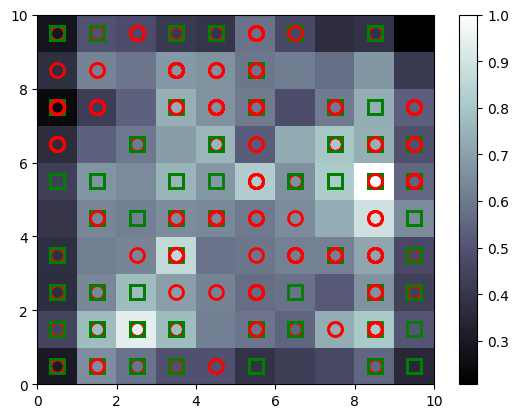

In [9]:
## Visualize the result
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
  w = som.winner(x)
  plot(w[0]+0.5,
       w[1]+0.5,
       markers[y[i]],
       markeredgecolor = colors[y[i]],
       markerfacecolor = 'None',
       markersize = 10,
       markeredgewidth = 2)
show()

In [10]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(8,5)], mappings[(2,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [13]:
np.set_printoptions(suppress=True)
print(frauds[:5])

[[15801441.           0.          35.75         0.915        2.
         6.           4.           0.75         1.           1.
         4.           0.           2.           0.        1584.   ]
 [15788131.           0.          29.5          0.46         2.
         4.           4.           0.54         1.           1.
         4.           0.           2.         380.         501.   ]
 [15699963.           0.          64.08         0.165        2.
         1.           1.           0.           1.           1.
         1.           0.           2.         232.         101.   ]
 [15808023.           0.          28.17         0.375        2.
        11.           4.           0.585        1.           1.
         4.           0.           2.          80.           1.   ]
 [15748649.           0.          21.25         2.335        2.
         3.           5.           0.5          1.           1.
         4.           0.           1.          80.           1.   ]]


In [14]:
frauds.shape

(10, 15)

### Part-2 : Going from Unsupervised to Supervised Deep Learning

#### Creating the Matrix of features

In [15]:
customers = dataset.iloc[:, 1:].values

#### Creating the Dependent variable

In [17]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

#### Feature Scaling

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

#### Let's make the ANN

In [20]:
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
690/690 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9649 - loss: 0.5938
Epoch 2/3
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9842 - loss: 0.1783
Epoch 3/3
690/690 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9801 - loss: 0.1018


### Predicting the probability of frauds

In [21]:
y_pred = classifier.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1],y_pred), axis = 1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [23]:
y_pred = y_pred[y_pred[:, 1].argsort()]

In [24]:
y_pred

array([[15621423.        ,        0.00321555],
       [15799785.        ,        0.00405524],
       [15790113.        ,        0.00794979],
       ...,
       [15636562.        ,        0.07733882],
       [15800773.        ,        0.08407908],
       [15748649.        ,        0.08817329]])

In [25]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1
